In [60]:
# Importing necessary libraries for visualization, modeling, and analysis
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


# Set seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

import warnings
warnings.filterwarnings("ignore")

In [61]:
# Define file paths
file_path_with_infertility = r"C:\Users\kanis\Downloads\PCOS_infertility.csv"
file_path_without_infertility = r"C:\Users\kanis\Downloads\PCOS_data_without_infertility.xlsx"

# Load data
PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

# Merge datasets based on 'Patient File No.'
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes=('', '_y'), how='left')

# Drop duplicated or unnecessary columns
columns_to_drop = ['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', 
                   '  I   beta-HCG(mIU/mL)_y', 'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y']
data = data.drop(columns=columns_to_drop, errors='ignore')

# Display first few rows
data.head()


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

In [63]:
# Load dataset 
summary_table = data.describe().T  # Transpose for better readability
summary_table[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]


,mean,std,min,25%,50%,75%,max
Sl. No,271.000000,156.317519,1.000000,136.000000,271.000000,406.000000,541.000000
Patient File No.,271.000000,156.317519,1.000000,136.000000,271.000000,406.000000,541.000000
PCOS (Y/N),0.327172,0.469615,0.000000,0.000000,0.000000,1.000000,1.000000
Age (yrs),31.430684,5.411006,20.000000,28.000000,31.000000,35.000000,48.000000
Weight (Kg),59.637153,11.028287,31.000000,52.000000,59.000000,65.000000,108.000000
Height(Cm),156.484835,6.033545,137.000000,152.000000,156.000000,160.000000,180.000000
BMI,24.311285,4.056399,12.417882,21.641274,24.238227,26.634958,38.900000
Blood Group,13.802218,1.840812,11.000000,13.000000,14.000000,15.000000,18.000000
Pulse rate(bpm),73.247689,4.430285,13.000000,72.000000,72.000000,74.000000,82.000000
RR (breaths/min),19.243993,1.688629,16.000000,18.000000,18.000000,20.000000,28.000000


In [64]:
data.shape

(541, 44)

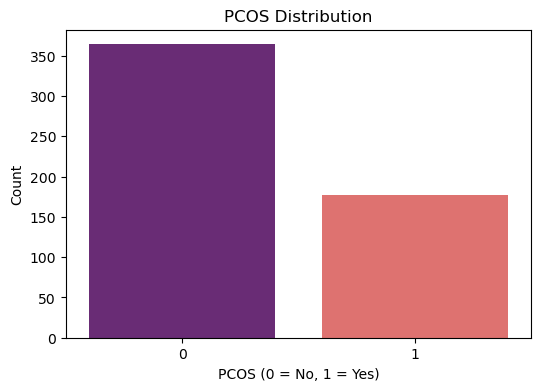

In [65]:
# Creating a count plot to visualize how many individuals have PCOS vs. those who don't
plt.figure(figsize=(6, 4))  # Set the plot size
sns.countplot(x='PCOS (Y/N)', data=data, palette='magma')  
plt.title("PCOS Distribution")  # Title for context
plt.xlabel("PCOS (0 = No, 1 = Yes)")  
plt.ylabel("Count")  # Label the y-axis
plt.show()  # Display the plot


In [66]:
# Calculate the percentage of individuals with and without PCOS
pcos_counts = data['PCOS (Y/N)'].value_counts(normalize=True) * 100
print(f"PCOS Positive: {pcos_counts[1]:.2f}%")  # Print percentage of positive cases
print(f"PCOS Negative: {pcos_counts[0]:.2f}%")  # Print percentage of negative cases


PCOS Positive: 32.72%
PCOS Negative: 67.28%


In [67]:
# Extract BMI values for PCOS and non-PCOS groups
bmi_pcos = data[data['PCOS (Y/N)'] == 1]['BMI']
bmi_non_pcos = data[data['PCOS (Y/N)'] == 0]['BMI']

# Calculate the average BMI for both groups
mean_pcos_bmi = np.mean(bmi_pcos)
mean_non_pcos_bmi = np.mean(bmi_non_pcos)

# Display average BMI comparison
print(f"Average BMI of PCOS Patients: {mean_pcos_bmi:.2f}")
print(f"Average BMI of Non-PCOS Patients: {mean_non_pcos_bmi:.2f}")


Average BMI of PCOS Patients: 25.47
Average BMI of Non-PCOS Patients: 23.75


In [68]:
# Perform a statistical t-test to compare LH (Luteinizing Hormone) levels between PCOS and non-PCOS groups
lh_pcos = data[data['PCOS (Y/N)'] == 1]['LH(mIU/mL)']
lh_non_pcos = data[data['PCOS (Y/N)'] == 0]['LH(mIU/mL)']

t_stat, p_value = stats.ttest_ind(lh_pcos, lh_non_pcos, equal_var=False)  # Welch’s t-test used due to unequal variance
print(f"T-test for LH levels: p-value = {p_value:.5f}")  # A low p-value indicates significant difference

T-test for LH levels: p-value = 0.30189


In [69]:
# Repeat the t-test process for FSH (Follicle-Stimulating Hormone) levels
fsh_pcos = data[data['PCOS (Y/N)'] == 1]['FSH(mIU/mL)']
fsh_non_pcos = data[data['PCOS (Y/N)'] == 0]['FSH(mIU/mL)']

t_stat, p_value = stats.ttest_ind(fsh_pcos, fsh_non_pcos, equal_var=False)
print(f"T-test for FSH levels: p-value = {p_value:.5f}")  # Useful to detect hormonal differences


T-test for FSH levels: p-value = 0.31317


In [70]:
# Irregular cycles pattern
irregular_cycles_pcos = data[data['PCOS (Y/N)'] == 1]['Cycle(R/I)'].value_counts(normalize=True) * 100
irregular_cycles_non_pcos = data[data['PCOS (Y/N)'] == 0]['Cycle(R/I)'].value_counts(normalize=True) * 100

print(f"PCOS Patients - Irregular Cycles: {irregular_cycles_pcos.get(1, 0):.2f}%")
print(f"Non-PCOS Patients - Irregular Cycles: {irregular_cycles_non_pcos.get(1, 0):.2f}%")


PCOS Patients - Irregular Cycles: 0.00%
Non-PCOS Patients - Irregular Cycles: 0.00%


In [71]:
# Investigate pregnancy status among PCOS patients
# 'Pregnant(Y/N)' might indicate prior pregnancy experience

infertility_pcos = data[data['PCOS (Y/N)'] == 1]['Pregnant(Y/N)'].value_counts(normalize=True) * 100

# Print the proportion of PCOS patients who have and have not been pregnant
print(f"Percentage of PCOS patients who have been pregnant: {infertility_pcos.get(1, 0):.2f}%")
print(f"Percentage of PCOS patients who have not been pregnant: {infertility_pcos.get(0, 0):.2f}%")


Percentage of PCOS patients who have been pregnant: 36.16%
Percentage of PCOS patients who have not been pregnant: 63.84%


In [72]:
# Create a summary table to compare mean values of key metrics across PCOS and non-PCOS groups
comparison_table = data.groupby('PCOS (Y/N)')[[' Age (yrs)', 'BMI', 'LH(mIU/mL)', 'FSH(mIU/mL)', 'Vit D3 (ng/mL)']].mean()

# Replace the binary index with human-readable labels
comparison_table.index = ['Non-PCOS', 'PCOS']

# Display the resulting summary table
comparison_table


,Age (yrs),BMI,LH(mIU/mL),FSH(mIU/mL),Vit D3 (ng/mL)
Non-PCOS,32.065934,23.747397,2.612676,19.185956,29.295005
PCOS,30.124294,25.470919,14.402328,5.174593,92.322633


In [73]:
# Selecting relevant columns
features = [' Age (yrs)', 'BMI', 'LH(mIU/mL)', 'FSH(mIU/mL)', 'Vit D3 (ng/mL)']
summary_table = data[features].describe().T[['mean', '50%', 'std', 'min', 'max']]
summary_table.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max']

# Display the table
summary_table


,Mean,Median,Std Dev,Min,Max
Age (yrs),31.430684,31.000000,5.411006,20.000000,48.00
BMI,24.311285,24.238227,4.056399,12.417882,38.90
LH(mIU/mL),6.469919,2.300000,86.673255,0.020000,2018.00
FSH(mIU/mL),14.601832,4.850000,217.022081,0.210000,5052.00
Vit D3 (ng/mL),49.915874,25.900000,346.206599,0.000000,6014.66


In [74]:
# Defining PCOS & Non-PCOS groups
pcos_group = data[data['PCOS (Y/N)'] == 1]
non_pcos_group = data[data['PCOS (Y/N)'] == 0]

# Performing t-tests
t_test_results = {
    'Feature': ['LH(mIU/mL)', 'FSH(mIU/mL)', 'BMI', 'Vit D3 (ng/mL)'],
    'P-Value': [
        ttest_ind(pcos_group['LH(mIU/mL)'], non_pcos_group['LH(mIU/mL)'], nan_policy='omit').pvalue,
        ttest_ind(pcos_group['FSH(mIU/mL)'], non_pcos_group['FSH(mIU/mL)'], nan_policy='omit').pvalue,
        ttest_ind(pcos_group['BMI'], non_pcos_group['BMI'], nan_policy='omit').pvalue,
        ttest_ind(pcos_group['Vit D3 (ng/mL)'], non_pcos_group['Vit D3 (ng/mL)'], nan_policy='omit').pvalue
    ]
}

t_test_df = pd.DataFrame(t_test_results)
t_test_df


,Feature,P-Value
0,LH(mIU/mL),0.137845
1,FSH(mIU/mL),0.481596
2,BMI,0.000003
3,Vit D3 (ng/mL),0.046857


In [75]:
# Create a new binary column indicating Vitamin D deficiency status (threshold: < 20 ng/mL)
data['Vit D Deficient'] = data['Vit D3 (ng/mL)'] < 20

# Calculate percentage of Vitamin D deficient and sufficient individuals within PCOS and Non-PCOS groups
vit_d_table = data.groupby('PCOS (Y/N)')['Vit D Deficient'].value_counts(normalize=True) * 100

# Reshape the results to make it easier to interpret as a table
vit_d_table = vit_d_table.unstack()

vit_d_table.columns = ['Sufficient (%)', 'Deficient (%)']
vit_d_table.index = ['Non-PCOS', 'PCOS']  

# Display the percentage of Vitamin D sufficiency/deficiency in both groups
vit_d_table



,Sufficient (%),Deficient (%)
Non-PCOS,81.043956,18.956044
PCOS,71.751412,28.248588


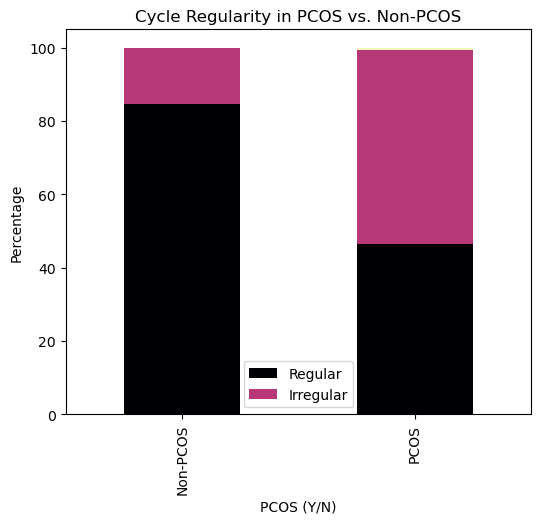

In [76]:
# Analyze cycle regularity (Regular vs Irregular) as a percentage within each PCOS class
cycle_counts = data.groupby('PCOS (Y/N)')['Cycle(R/I)'].value_counts(normalize=True).unstack() * 100

# Plot a stacked bar chart to compare cycle regularity between PCOS and Non-PCOS groups
cycle_counts.plot(
    kind='bar', 
    stacked=True, 
    colormap='magma', 
    figsize=(6,5)
)
plt.xticks([0,1], ['Non-PCOS', 'PCOS']) 
plt.ylabel("Percentage")
plt.title("Cycle Regularity in PCOS vs. Non-PCOS")
plt.legend(["Regular", "Irregular"])  
plt.show()


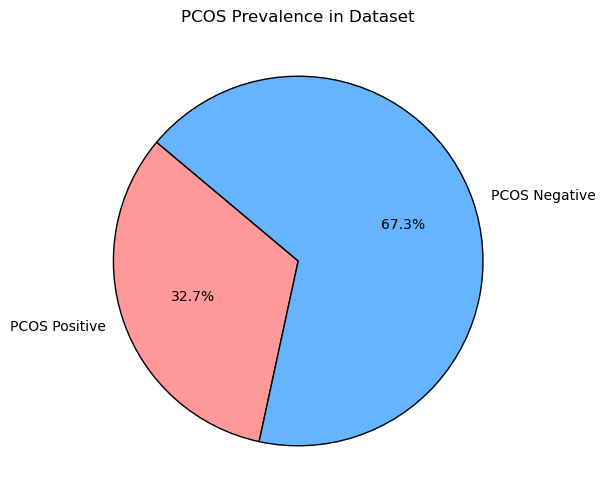

In [77]:
# Create a pie chart to visualize overall PCOS prevalence in the dataset

labels = ['PCOS Positive', 'PCOS Negative']  # Define pie segments
sizes = [32.72, 67.28]  
colors = ['#FF9999', '#66B3FF']  

plt.figure(figsize=(6,6))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%',  # Show percentage values on pie
    colors=colors, 
    startangle=140,  # Rotate the pie 
    wedgeprops={'edgecolor': 'black'}  # black edge for better visibility
)
plt.title("PCOS Prevalence in Dataset")
plt.show()


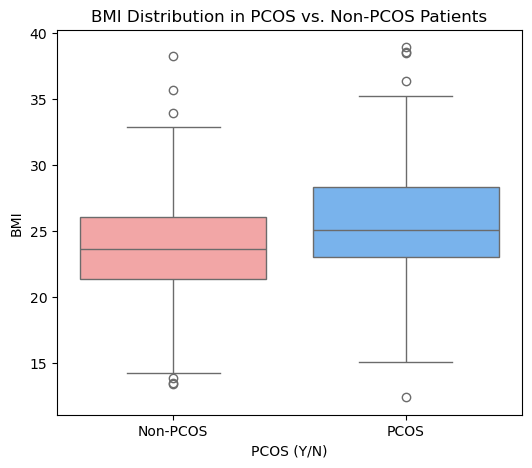

In [78]:
# Create a boxplot to visualize the distribution of BMI across PCOS and Non-PCOS patients

plt.figure(figsize=(6,5))
sns.boxplot(
    x='PCOS (Y/N)', 
    y='BMI', 
    data=data, 
    palette=['#FF9999', '#66B3FF'] 
)
plt.xticks([0,1], ['Non-PCOS', 'PCOS']) 
plt.title("BMI Distribution in PCOS vs. Non-PCOS Patients")  
plt.show()


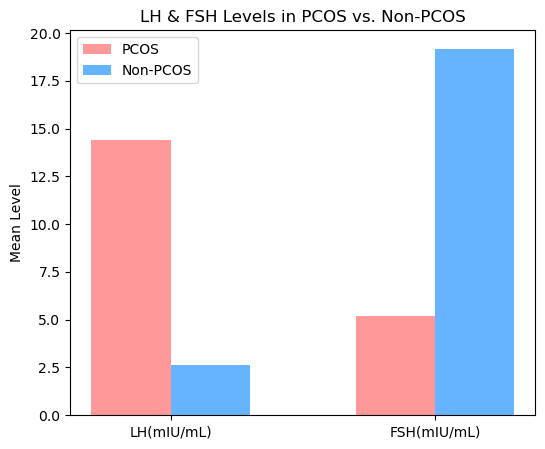

In [79]:
# Compare mean levels of two hormones (LH and FSH) between PCOS and Non-PCOS groups using a grouped bar chart
hormones = ['LH(mIU/mL)', 'FSH(mIU/mL)']  # Hormones of interest

# Calculate mean hormone levels for PCOS group
means_pcos = [
    data[data['PCOS (Y/N)'] == 1]['LH(mIU/mL)'].mean(), 
    data[data['PCOS (Y/N)'] == 1]['FSH(mIU/mL)'].mean()
]

# same for Non-PCOS group
means_non_pcos = [
    data[data['PCOS (Y/N)'] == 0]['LH(mIU/mL)'].mean(), 
    data[data['PCOS (Y/N)'] == 0]['FSH(mIU/mL)'].mean()
]

x = np.arange(len(hormones))  # X-axis positions for bars
width = 0.3  

# Create the bar chart
fig, ax = plt.subplots(figsize=(6,5))
ax.bar(x - width/2, means_pcos, width, label='PCOS', color='#FF9999')  # PCOS bars
ax.bar(x + width/2, means_non_pcos, width, label='Non-PCOS', color='#66B3FF')  # Non-PCOS bars

# Format the plot
ax.set_xticks(x)
ax.set_xticklabels(hormones)
ax.set_ylabel('Mean Level')
ax.set_title('LH & FSH Levels in PCOS vs. Non-PCOS')
ax.legend()
plt.show()


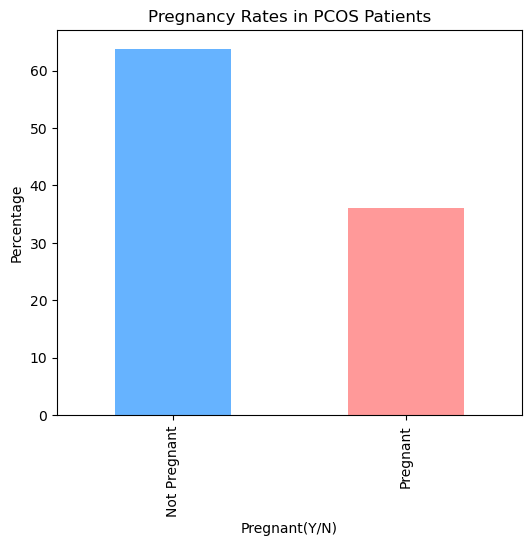

In [80]:
# Analyze pregnancy status distribution among PCOS patients

pregnancy_counts = data[data['PCOS (Y/N)'] == 1]['Pregnant(Y/N)'].value_counts(normalize=True) * 100

# Plot a simple bar chart to show pregnancy rates within PCOS patients
pregnancy_counts.plot(
    kind='bar', 
    color=['#66B3FF', '#FF9999'], 
    figsize=(6,5)
)
plt.xticks([0,1], ['Not Pregnant', 'Pregnant'])  
plt.ylabel("Percentage")
plt.title("Pregnancy Rates in PCOS Patients")
plt.show()



In [81]:
# Checking for missing values
missing_values = data.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

Marraige Status (Yrs)    1
Fast food (Y/N)          1
dtype: int64

In [82]:
# Handling missing values 
data.fillna(data.median(numeric_only=True), inplace=True)  # Filling numerical missing values with median


In [83]:
# Checking for missing values
missing_values = data.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

Series([], dtype: int64)

In [84]:
# Checking for duplicate rows
duplicate_rows = data.duplicated().sum()
print(f"Total duplicate rows: {duplicate_rows}")

# Dropping duplicate rows
data = data.drop_duplicates()


Total duplicate rows: 0


In [85]:
# Calculating Z-scores
z_scores = data.select_dtypes(include=['number']).apply(zscore)

# Setting threshold (e.g., |z| > 3 indicates an outlier)
outliers = (z_scores.abs() > 3).sum()
print(outliers[outliers > 0])  # Display features with outliers


 Age (yrs)                 1
Weight (Kg)                3
Height(Cm)                 2
BMI                        4
Pulse rate(bpm)            2
RR (breaths/min)           3
Hb(g/dl)                   8
Cycle length(days)         9
Marraige Status (Yrs)      7
No. of aborptions         13
  I   beta-HCG(mIU/mL)     9
FSH(mIU/mL)                1
LH(mIU/mL)                 1
FSH/LH                     2
Hip(inch)                  3
Waist(inch)                3
TSH (mIU/L)                9
PRL(ng/mL)                 9
Vit D3 (ng/mL)             2
PRG(ng/mL)                 2
RBS(mg/dl)                 4
BP _Systolic (mmHg)        3
BP _Diastolic (mmHg)       3
Follicle No. (L)           6
Follicle No. (R)           6
Avg. F size (L) (mm)       8
Avg. F size (R) (mm)       5
Endometrium (mm)           6
dtype: int64


In [86]:
# Identifying categorical features
categorical_features = data.select_dtypes(include=['object']).columns

# Applying one-hot encoding for categorical features
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)


In [87]:
# Initializing the scaler
scaler = StandardScaler()

# Scaling numerical features
numerical_features = data.select_dtypes(include=['number']).columns
data[numerical_features] = scaler.fit_transform(data[numerical_features])



Model: Random Forest
Accuracy : 0.9384
Precision: 0.9583
Recall   : 0.9200
F1-Score : 0.9388

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        71
           1       0.96      0.92      0.94        75

    accuracy                           0.94       146
   macro avg       0.94      0.94      0.94       146
weighted avg       0.94      0.94      0.94       146



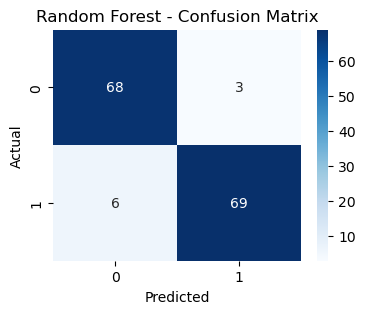


Model: Decision Tree
Accuracy : 0.8493
Precision: 0.8955
Recall   : 0.8000
F1-Score : 0.8451

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        71
           1       0.90      0.80      0.85        75

    accuracy                           0.85       146
   macro avg       0.85      0.85      0.85       146
weighted avg       0.85      0.85      0.85       146



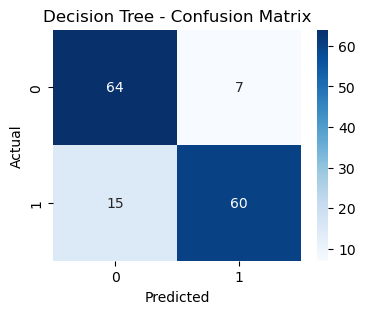


Model: Gaussian NB
Accuracy : 0.7329
Precision: 0.6667
Recall   : 0.9600
F1-Score : 0.7869

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.49      0.64        71
           1       0.67      0.96      0.79        75

    accuracy                           0.73       146
   macro avg       0.79      0.73      0.71       146
weighted avg       0.79      0.73      0.72       146



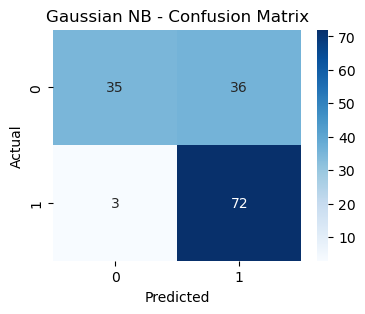


Model: Logistic Regression
Accuracy : 0.9110
Precision: 0.9079
Recall   : 0.9200
F1-Score : 0.9139

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91        71
           1       0.91      0.92      0.91        75

    accuracy                           0.91       146
   macro avg       0.91      0.91      0.91       146
weighted avg       0.91      0.91      0.91       146



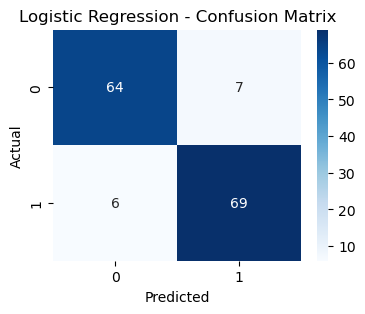

In [88]:
# Ensure target column is in correct format
data['PCOS (Y/N)'] = data['PCOS (Y/N)'].astype(int)

# Features and target
X = data.drop(columns=['PCOS (Y/N)'])
y = data['PCOS (Y/N)']

# Handle imbalance using SMOTE
smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=SEED)

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'Decision Tree': DecisionTreeClassifier(random_state=SEED),
    'Gaussian NB': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear')
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nModel: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [89]:
# Removing low-variance features
selector = VarianceThreshold(threshold=0.01)  # Adjust the threshold as needed
data = pd.DataFrame(selector.fit_transform(data), columns=data.columns[selector.get_support()])


In [90]:
# Ensure target column is integer type
data['PCOS (Y/N)'] = data['PCOS (Y/N)'].astype(int)

# Fill any remaining missing values (using a simple strategy for this example)
data = data.fillna(data.median(numeric_only=True))

# Define features (X) and target (y) from your full dataset
X = data.drop(columns=['PCOS (Y/N)'])
y = data['PCOS (Y/N)']

# Ensure all feature columns are float32 for TensorFlow
X = X.astype('float32')

# Define the number of splits for cross-validation
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# Lists to store the performance scores from each fold
fold_f1_scores = []
fold_accuracy_scores = []

# Loop through each fold
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"========== FOLD {fold+1}/{N_SPLITS} ==========")

    # Split data for the current fold 
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Apply SMOTE only to the training data of this fold 
    # This is critical to prevent data leakage.
    smote = SMOTE(random_state=SEED)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Convert to NumPy arrays for TensorFlow
    X_train_np = X_train_resampled.to_numpy().astype('float32')
    X_val_np = X_val_fold.to_numpy().astype('float32')

    # Define and train the Autoencoder on this fold's training data
    input_dim = X_train_np.shape[1]
    encoding_dim = 64

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    
    autoencoder = Model(input_layer, decoded, name="Autoencoder")
    encoder = Model(input_layer, encoded, name="Encoder")
    
    autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                    loss='mean_squared_logarithmic_error')
    
    print(f"Training Autoencoder for Fold {fold+1}...")
    autoencoder.fit(X_train_np, X_train_np, epochs=120, batch_size=64, shuffle=True, verbose=0)

    # Extract features using the trained encoder 
    X_train_encoded = encoder.predict(X_train_np, verbose=0)
    X_val_encoded = encoder.predict(X_val_np, verbose=0)

    # Train the Random Forest classifier on the encoded training data
    print(f"Training Random Forest for Fold {fold+1}...")
    rf_classifier = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=SEED)
    rf_classifier.fit(X_train_encoded, y_train_resampled)

    # Evaluate on the validation set for this fold
    y_pred_fold = rf_classifier.predict(X_val_encoded)
    
    f1 = f1_score(y_val_fold, y_pred_fold, average='weighted')
    acc = accuracy_score(y_val_fold, y_pred_fold)
    
    fold_f1_scores.append(f1)
    fold_accuracy_scores.append(acc)
    print(f"Fold {fold+1} -> F1-Score: {f1:.4f}, Accuracy: {acc:.4f}\n")

print("\nCROSS-VALIDATION SUMMARY")
print(f"The model's performance was validated using {N_SPLITS}-fold cross-validation.")
print(f"Average F1-Score    : {np.mean(fold_f1_scores):.4f} (+/- {np.std(fold_f1_scores):.4f})")
print(f"Average Accuracy    : {np.mean(fold_accuracy_scores):.4f} (+/- {np.std(fold_accuracy_scores):.4f})")


========== FOLD 1/5 ==========
Training Autoencoder for Fold 1...
Training Random Forest for Fold 1...
Fold 1 -> F1-Score: 0.8881, Accuracy: 0.8899

========== FOLD 2/5 ==========
Training Autoencoder for Fold 2...
Training Random Forest for Fold 2...
Fold 2 -> F1-Score: 0.8720, Accuracy: 0.8704

========== FOLD 3/5 ==========
Training Autoencoder for Fold 3...
Training Random Forest for Fold 3...
Fold 3 -> F1-Score: 0.9247, Accuracy: 0.9259

========== FOLD 4/5 ==========
Training Autoencoder for Fold 4...
Training Random Forest for Fold 4...
Fold 4 -> F1-Score: 0.8117, Accuracy: 0.8148

========== FOLD 5/5 ==========
Training Autoencoder for Fold 5...
Training Random Forest for Fold 5...
Fold 5 -> F1-Score: 0.8683, Accuracy: 0.8704


CROSS-VALIDATION SUMMARY
The model's performance was validated using 5-fold cross-validation.
Average F1-Score    : 0.8730 (+/- 0.0366)
Average Accuracy    : 0.8743 (+/- 0.0360)


In [91]:
print("\nTRAINING FINAL MODEL FOR VISUALIZATION")

# Apply SMOTE to the entire dataset to create a balanced set for training
smote_final = SMOTE(random_state=SEED)
X_resampled_full, y_resampled_full = smote_final.fit_resample(X, y)

# Split this balanced data into a final training and testing set for plotting
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_resampled_full, y_resampled_full, test_size=0.2, random_state=SEED
)

# Convert to NumPy arrays for TensorFlow
X_train_np_final = X_train_final.to_numpy().astype('float32')
X_test_np_final = X_test_final.to_numpy().astype('float32')

# 3. Train the Autoencoder on the final training set
print("Training final Autoencoder...")
input_dim = X_train_np_final.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

final_autoencoder = Model(input_layer, decoded, name="Final_Autoencoder")
final_encoder = Model(input_layer, encoded, name="Final_Encoder")

final_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
final_autoencoder.fit(X_train_np_final, X_train_np_final, epochs=100, batch_size=32, verbose=0)

# 4. Extract features using the final encoder
X_train_encoded_final = final_encoder.predict(X_train_np_final, verbose=0)
X_test_encoded_final = final_encoder.predict(X_test_np_final, verbose=0)

# 5. Train the final Random Forest classifier
print("Training final Random Forest...")
final_rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=SEED)
final_rf_model.fit(X_train_encoded_final, y_train_final)

print("Final model training complete.")

# Get the predicted probabilities for the positive class
y_pred_proba = final_rf_model.predict_proba(X_test_encoded_final)[:, 1]
# Get the predicted classes
y_pred_final = final_rf_model.predict(X_test_encoded_final)



TRAINING FINAL MODEL FOR VISUALIZATION
Training final Autoencoder...
Training final Random Forest...
Final model training complete.


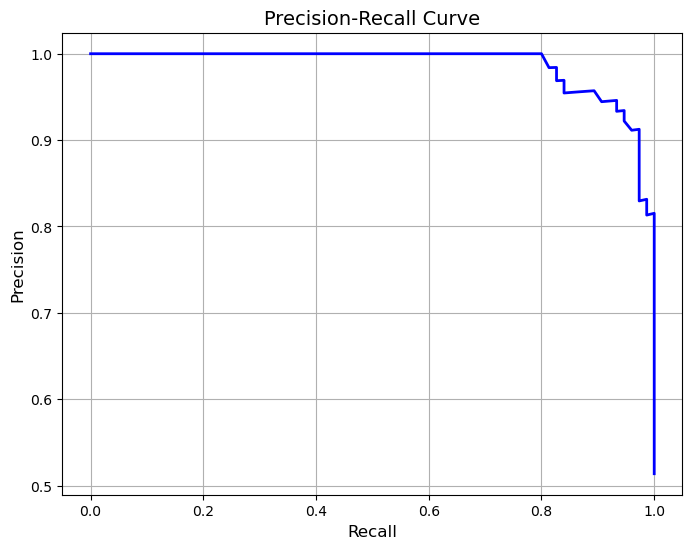

In [92]:
#Precision Recall Curve Visualisation
precision, recall, _ = precision_recall_curve(y_test_final, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.grid(True)
plt.show()

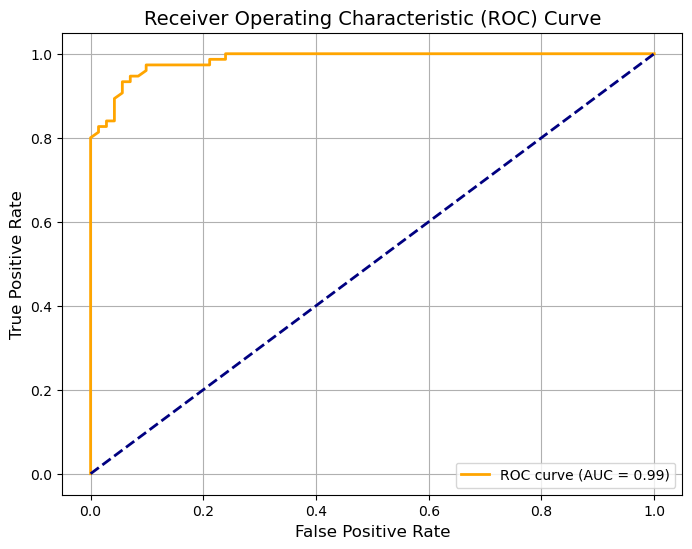

In [93]:
# ROC CURVE Visualisation
fpr, tpr, _ = roc_curve(y_test_final, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

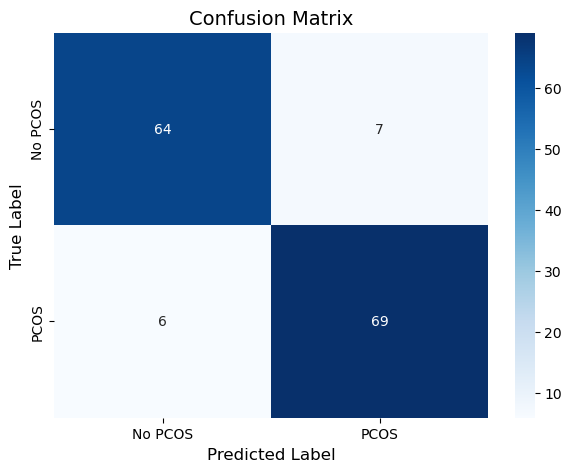

              precision    recall  f1-score   support

     No PCOS       0.93      0.93      0.93        71
        PCOS       0.93      0.93      0.93        75

    accuracy                           0.93       146
   macro avg       0.93      0.93      0.93       146
weighted avg       0.93      0.93      0.93       146



In [94]:
# Confusion Matrix Visualisation
cm = confusion_matrix(y_test_final, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No PCOS', 'PCOS'],
            yticklabels=['No PCOS', 'PCOS'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# Classification report
print(classification_report(y_test_final, y_pred_final, target_names=['No PCOS', 'PCOS']))

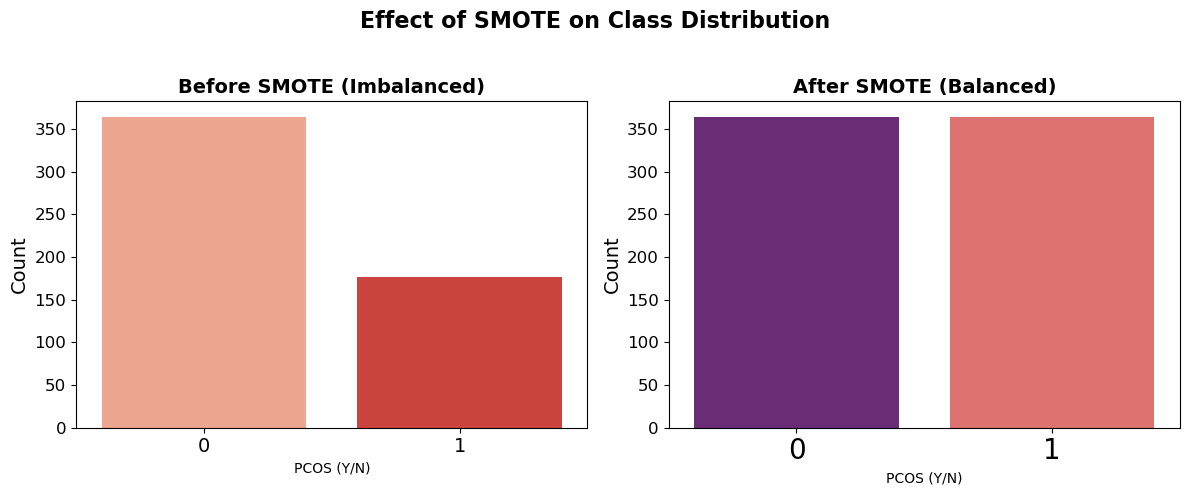

In [95]:
# Effect of SMOTE on Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y, ax=axes[0], palette='Reds')
axes[0].set_title('Before SMOTE (Imbalanced)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].tick_params(axis='x', labelsize=14)  

sns.countplot(x=y_resampled, ax=axes[1], palette='magma')
axes[1].set_title('After SMOTE (Balanced)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='x', labelsize=20)  

plt.suptitle('Effect of SMOTE on Class Distribution', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlap
plt.show()
